# DATA EDA

### Imports

In [1]:
#Imports
import pandas as pd
from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
import xgboost as xgb

from sklearn import set_config
set_config(display = 'diagram')

# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier

### Dataframes Imports 

In [2]:
#Importing Transactions data
transactions_df= pd.read_csv("raw_data/transactions_v2.csv",nrows=900000)
#Importing user logs data
user_logs_df = pd.read_csv("raw_data/user_logs_v2.csv",nrows=900000)
#importing members data
members_df = pd.read_csv("raw_data/members_v3.csv",nrows=900000)
# import training dataset
train_df = pd.read_csv("raw_data/train_v2.csv",nrows=900000)

### Transactions Data

In [3]:
transactions = pd.read_csv("raw_data/transactions_v2.csv", nrows=30000)

In [4]:
# converting transaction_date and membership_date to datetime object
transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'], format='%Y%m%d')
transactions_df['membership_expire_date'] = pd.to_datetime(transactions_df['membership_expire_date'], format='%Y%m%d')

In [5]:
# removing duplicates and leaving only the latest transaction date
transactions_df_lt = transactions_df.loc[transactions_df.groupby('msno').transaction_date.idxmax()].reset_index(drop=True)

In [6]:
# sorting transaction rows by date in decending order 
transaction = transactions.sort_values(by=['transaction_date'], ascending=[False]).reset_index(drop=True)

In [7]:
# creating remaining plan duration column
transactions_df_lt['remaining_plan_duration'] = transactions_df_lt['membership_expire_date'] - transactions_df_lt['transaction_date']

In [8]:
# creating discount column
transactions_df_lt['is_discount'] = transactions_df_lt.apply(lambda x: '0' if (x['actual_amount_paid'] -x['plan_list_price'])>=0 else '1', axis=1)

In [9]:
transactions_df_lt.head(2)

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,remaining_plan_duration,is_discount
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,22,395,1599,1599,0,2016-10-23,2018-02-06,0,471 days,0
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,30,149,149,1,2017-03-31,2017-05-19,0,49 days,0


In [10]:
transactions_df_lt['is_discount_rel'] = ((transactions_df_lt.plan_list_price- transactions_df_lt.actual_amount_paid)/transactions_df_lt.plan_list_price)*100

In [11]:
transactions_df_lt =  transactions_df_lt[transactions_df_lt.is_discount_rel >=0]
transactions_df_lt.is_discount_rel.value_counts()

is_discount_rel
0.000000      780073
100.000000      1639
33.557047        408
13.422819        142
20.134228          8
0.666667           1
0.559284           1
0.447427           1
5.033557           1
Name: count, dtype: int64

### User logs Data

In [12]:
# Converting date into datetime object
user_logs_df['date'] = pd.to_datetime(user_logs_df['date'], format='%Y%m%d')

In [13]:
#create new dataframe from transactions table with only msno and latest transaction date
latest_transactions_per_msno = transactions_df_lt[['msno', 'transaction_date']]

In [14]:
# latest_transactions_per_msno.head(3)

In [15]:
#Merge user logs with latest transaction date
merged_df = user_logs_df.merge(latest_transactions_per_msno, on='msno', how='left')

In [16]:
# drop msno's where transaction date is NaN
merged_df = merged_df.dropna(subset=['transaction_date'])

In [17]:
#removing rows where the user log data is before the last transaction date
user_logs_atd= merged_df.loc[merged_df['date']>=merged_df['transaction_date']]

In [18]:
# removing data column
user_logs_atd = user_logs_atd.drop(columns=['date','transaction_date'])

In [19]:
#groupby msno and summing all values
user_logs_atd = user_logs_atd.groupby('msno').mean()

### Merging

In [20]:
# Merging transactions, user logs and members data to Train dataframe
train_df = train_df.merge(transactions_df_lt, on='msno', how='left')
train_df = train_df.merge(user_logs_atd, on='msno', how='left')
train_df = train_df.merge(members_df, on='msno', how='left')

In [21]:
train_df.columns

Index(['msno', 'is_churn', 'payment_method_id', 'payment_plan_days',
       'plan_list_price', 'actual_amount_paid', 'is_auto_renew',
       'transaction_date', 'membership_expire_date', 'is_cancel',
       'remaining_plan_duration', 'is_discount', 'is_discount_rel', 'num_25',
       'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs',
       'city', 'bd', 'gender', 'registered_via', 'registration_init_time'],
      dtype='object')

### Exploration

In [22]:
train_df.isnull().sum()

msno                            0
is_churn                        0
payment_method_id          330887
payment_plan_days          330887
plan_list_price            330887
actual_amount_paid         330887
is_auto_renew              330887
transaction_date           330887
membership_expire_date     330887
is_cancel                  330887
remaining_plan_duration    330887
is_discount                330887
is_discount_rel            330887
num_25                     763516
num_50                     763516
num_75                     763516
num_985                    763516
num_100                    763516
num_unq                    763516
total_secs                 763516
city                       778260
bd                         778260
gender                     835523
registered_via             778260
registration_init_time     778260
dtype: int64

In [23]:
new_cor = train_df.drop(["msno","gender"], axis=1)
# new_cor

In [24]:
train_df.bd.value_counts()

bd
0.0       57534
27.0       3809
26.0       3657
28.0       3600
29.0       3450
          ...  
1820.0        1
1043.0        1
1017.0        1
936.0         1
115.0         1
Name: count, Length: 129, dtype: int64

/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='bd'>

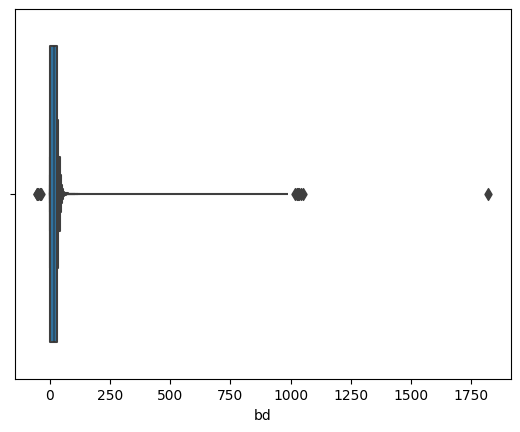

In [25]:
sns.boxenplot(x="bd", data=train_df)

In [108]:
percentile25 = train_df['bd'].quantile(0.5)
percentile75 = train_df['bd'].quantile(0.80)

In [109]:
percentile25

19.0

In [110]:
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Upper limit",upper_limit)
print("Lower limit",lower_limit)

Upper limit 51.5
Lower limit -0.5


In [29]:
train_df[train_df["bd"] > upper_limit]

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,...,num_75,num_985,num_100,num_unq,total_secs,city,bd,gender,registered_via,registration_init_time
768,lNYy0aOP0/UDtNldut3A/98YEvUSVWneCEy3kiulvOM=,1,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,60.0,male,3.0,20120907.0
1125,lNVtZjnkC07RG5DeMqZRu3Pdwh6qhskhPb+Y/06BTP8=,1,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,13.0,63.0,male,9.0,20111118.0
1554,YtIhLU0dNR8+0iHcJP9NuCDJxB9kXBiZ9R2YHUyGZZY=,1,32.0,395.0,1599.0,1599.0,0.0,2016-12-25,2018-04-28,0.0,...,NaN,NaN,NaN,NaN,NaN,6.0,52.0,female,9.0,20100613.0
1951,rzNj8NZi7axHFBMj1K6UzaCtNvNs847WhO0xCgCxnGE=,1,33.0,30.0,149.0,149.0,1.0,2017-02-28,2017-05-05,0.0,...,NaN,NaN,NaN,NaN,NaN,3.0,57.0,female,9.0,20080107.0
2773,SQbdETAhkX3njcNwibA9E3aE77BYId2rvlOVygC1IjI=,1,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,58.0,female,9.0,20070805.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895609,gJLdP2QiVbKud3K6KRQTQ5GQy2Fz/qFyZn1WQ2BS+r4=,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,22.0,52.0,male,9.0,20060920.0
895864,OKS+jhmaryUt698buDv3P2w/bnziLKb2YR8IIFTwims=,0,34.0,30.0,149.0,149.0,1.0,2017-03-31,2017-04-30,0.0,...,NaN,NaN,NaN,NaN,NaN,9.0,64.0,male,9.0,20090514.0
896796,rztOEp6D/QT78xiLfqs4Um+RrpwyD975MgIZld5tnzM=,0,39.0,30.0,149.0,149.0,1.0,2017-03-31,2017-05-26,0.0,...,NaN,NaN,NaN,NaN,NaN,9.0,115.0,male,3.0,20130210.0
897769,TiOhQwnumQ4N0cEFN2HPKHINl6/JXxPH5PLDFhdERI8=,0,31.0,30.0,149.0,149.0,1.0,2017-03-31,2017-04-30,0.0,...,NaN,NaN,NaN,NaN,NaN,17.0,57.0,male,3.0,20150320.0


In [30]:
train_df[train_df["bd"] <lower_limit]

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,...,num_75,num_985,num_100,num_unq,total_secs,city,bd,gender,registered_via,registration_init_time
58299,pbwQUaAv8Sj1Uo3uHxtySpoi4zxf0O6MFOh1hJ6rH0I=,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,13.0,-42.0,NaN,9.0,20150524.0
190769,Fm0ZPqLLmf6a0rkWOKQn/60Vz0vA+UqR2MJR5Gb5bRs=,0,40.0,30.0,149.0,149.0,1.0,2017-03-15,2017-04-17,0.0,...,NaN,NaN,NaN,NaN,NaN,6.0,-47.0,NaN,9.0,20150411.0
353058,eY+UDYaAlACNn21sfSJ2qWdwqkRkOwjUvrzuhFdQy74=,0,34.0,30.0,149.0,149.0,1.0,2017-03-31,2017-04-30,0.0,...,NaN,NaN,NaN,NaN,NaN,12.0,-39.0,female,7.0,20110423.0
372052,PaCrQ5+uc2vY0LTlqjHyA56CpdlggH8zbnkBnC3NIoQ=,0,40.0,30.0,149.0,149.0,1.0,2017-03-14,2017-04-18,0.0,...,0.0,0.0,0.0,1.0,7.04,13.0,-37.0,NaN,9.0,20150412.0
646297,T3AH9ITIJQR8ww0WoahoWqb3LYTtt3bs+MylUHTPG5s=,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,22.0,-51.0,NaN,9.0,20150320.0
892227,HFBBqocC+6wvGIQseRHByJCUE9wrubAU2Fm8db3RfyU=,0,40.0,30.0,149.0,149.0,1.0,2017-03-14,2017-04-16,0.0,...,NaN,NaN,NaN,NaN,NaN,9.0,-51.0,NaN,3.0,20130102.0


In [31]:
train_df_n = train_df.copy()

In [32]:
train_df_n = train_df_n[train_df_n.bd<upper_limit]
train_df_n = train_df_n[train_df_n.bd>lower_limit]

/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='bd'>

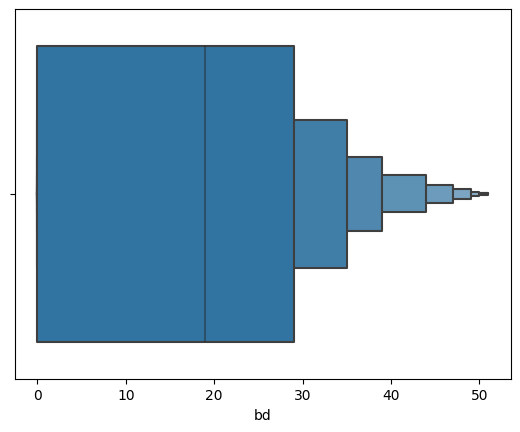

In [33]:
sns.boxenplot(x="bd", data=train_df_n)

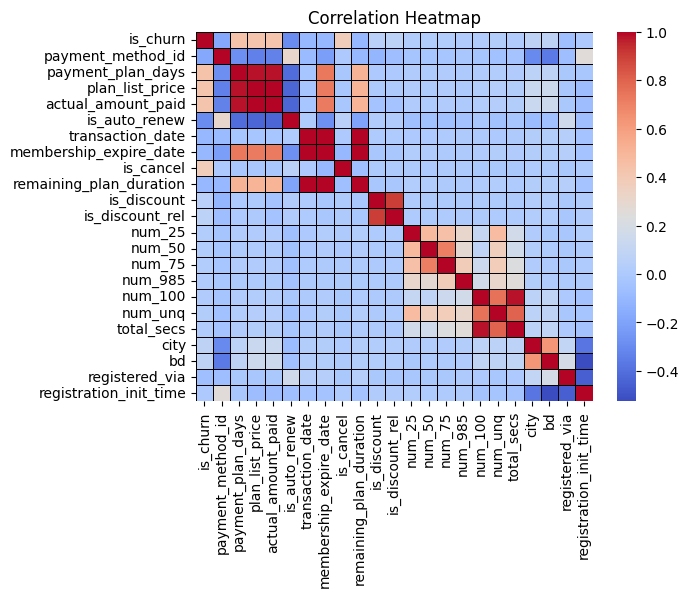

In [34]:

# new_cor is train_df.drop(["msno","gender"], axis=1)
new_cor = train_df_n.drop(["msno","gender"], axis=1)
corr_matrix = new_cor.corr()
heatmap = sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlation Heatmap')
plt.show()

In [35]:
train_df_n.dtypes.value_counts()

float64            18
object              3
datetime64[ns]      2
int64               1
timedelta64[ns]     1
Name: count, dtype: int64

In [41]:
X=train_df_n.drop(columns=["is_churn","gender","msno"])
y= train_df_n.is_churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:

X.select_dtypes(include=['object']).value_counts()

is_discount
0              76407
1                200
Name: count, dtype: int64

In [43]:
# baseline pipe 


In [44]:
preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    MinMaxScaler(), 
    # OneHotEncoder()
)

preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, make_column_selector(dtype_include=["int64", "float64"])),
    remainder="drop"
)

preproc_baseline

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fca0a9c86d0>)])

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [56]:
from sklearn.ensemble import RandomForestClassifier
models = [
    RandomForestClassifier(n_estimators=100),
    LogisticRegression(solver='lbfgs', max_iter=1000),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    KNeighborsClassifier(),
    XGBClassifier(),
    GradientBoostingClassifier(),
    VotingClassifier(estimators=[('gbr', GradientBoostingClassifier()), ('xgb', XGBClassifier())]),
    StackingClassifier(
            estimators=[('gbr', GradientBoostingClassifier())],
            final_estimator=XGBClassifier()),
    AdaBoostClassifier(
            base_estimator=GradientBoostingClassifier(),
            n_estimators=100),
    BaggingClassifier(
            base_estimator=GradientBoostingClassifier(),
            n_estimators=3,
            bootstrap=True)
        
]

In [57]:
# pipe_baseline = make_pipeline(preproc_baseline, VotingClassifier(estimators=[('gbr', GradientBoostingClassifier()), ('xgb', XGBClassifier())]))
# pipe_baseline.fit(X_train, y_train)
# y_pred = pipe_baseline.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# scores = cross_val_score(VotingClassifier(estimators=[('gbr', GradientBoostingClassifier()), ('xgb', XGBClassifier())]), X, y, cv=5)

# print(f"Accuracy: {accuracy:.2f}")
# print(f"cv: {scores:.2f}")


In [58]:
# for model in models:
#     pipe_baseline = make_pipeline(preproc_baseline, model)
#     pipe_baseline.fit(X_train, y_train)
#     y_pred = pipe_baseline.predict(X_test)
#     # for i in range(len(y_pred)):
#     #     if y_pred[i]<0.5:
#     #         y_pred[i]=0
#     #     else:
#     #         y_pred[i]=1

#     accuracy = accuracy_score(y_test, y_pred)
#     print(f"Accuracy: {accuracy:.2f}")
    

In [59]:
preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=50, # keep only 25% of all features
)

preproc = make_pipeline(
    preproc_baseline,
    preproc_selector,
    DecisionTreeClassifier()
    
)

In [60]:
y_train

521033    0
849344    0
352960    0
285503    0
9790      1
         ..
577520    0
828328    0
778105    0
6185      1
115037    0
Name: is_churn, Length: 95807, dtype: int64

In [61]:
preproc.fit(X_train,y_train)
y_pred = preproc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.91


In [74]:
selected_features_mask = preproc_selector.get_support()
# print(selected_features_mask)
# print(X_train.select_dtypes(include="float").columns)
print(f"Columns selected: {X_train.select_dtypes(include='float').columns[selected_features_mask]}")

Columns selected: Index(['payment_method_id', 'payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'is_auto_renew', 'is_cancel', 'is_discount_rel',
       'bd', 'registered_via'],
      dtype='object')


In [76]:
for model in models:
    preproc = make_pipeline(
    preproc_baseline,
    # preproc_selector,
    model
    )
    preproc.fit(X_train, y_train)
    y_pred = preproc.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {model} is: {accuracy:.2f}")
    

Accuracy of RandomForestClassifier() is: 0.90
Accuracy of LogisticRegression(max_iter=1000) is: 0.91
Accuracy of DecisionTreeClassifier() is: 0.87
Accuracy of AdaBoostClassifier() is: 0.91
Accuracy of KNeighborsClassifier() is: 0.91


/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Accuracy of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) is: 0.92
Accuracy of GradientBoostingClassifier() is: 0.92
Accuracy of VotingClassifier(estimators=[('gbr', GradientBoostingClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None,

/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy of AdaBoostClassifier(base_estimator=GradientBoostingClassifier(),
                   n_estimators=100) is: 0.91


/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy of BaggingClassifier(base_estimator=GradientBoostingClassifier(), n_estimators=3) is: 0.92


In [78]:
preproc = make_pipeline(
    preproc_baseline,
    preproc_selector,
    LogisticRegression(max_iter=1000)
    )

# preproc.fit(X_train,y_train)
# y_pred = preproc.predict(X_test)

scores = cross_val_score(preproc, X, y, cv=5)

# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.2f}")
print(f"cross val score :{scores.mean()}")

cross val score :0.9162401135200133


In [80]:
for model in models:
    preproc = make_pipeline(
    preproc_baseline,
    # preproc_selector,
    model
    )
    scores = cross_val_score(preproc, X, y, cv=5)
    print(f"Accuracy of {model} is: {scores.mean():.2f}")
    

Accuracy of RandomForestClassifier() is: 0.90
Accuracy of LogisticRegression(max_iter=1000) is: 0.92
Accuracy of DecisionTreeClassifier() is: 0.87
Accuracy of AdaBoostClassifier() is: 0.92
Accuracy of KNeighborsClassifier() is: 0.91


/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, 

Accuracy of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) is: 0.92
Accuracy of GradientBoostingClassifier() is: 0.92
Accuracy of VotingClassifier(estimators=[('gbr', GradientBoostingClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None,

/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


KeyboardInterrupt: 

/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='plan_list_price'>

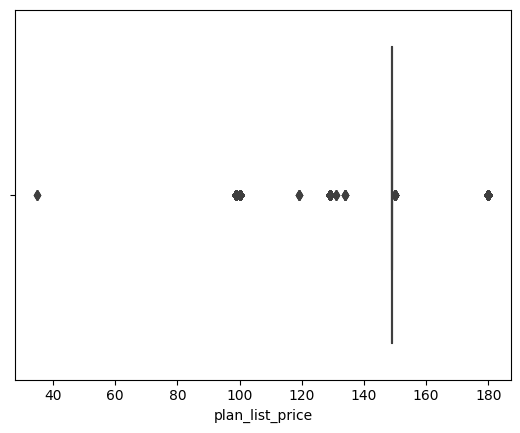

In [127]:
sns.boxplot(x='plan_list_price', data=train_df_n)

In [172]:
percentile25_n = train_df_n['plan_list_price'].quantile(0.05)
percentile75_n = train_df_n['plan_list_price'].quantile(0.90)

print(percentile25_n)
print(percentile75_n)

nan
nan


In [167]:
iqr = percentile75_n - percentile25_n
upper_limit_n = percentile75_n + 1.5 * iqr
lower_limit_n = percentile25_n - 1.5 * iqr
print("Upper limit",upper_limit_n)
print("Lower limit",lower_limit_n)

Upper limit 149.0
Lower limit 149.0


In [168]:
train_df_n = train_df_n[train_df_n.plan_list_price<upper_limit_n]
train_df_n = train_df_n[train_df_n.plan_list_price>lower_limit_n]

/home/nazneen/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='plan_list_price'>

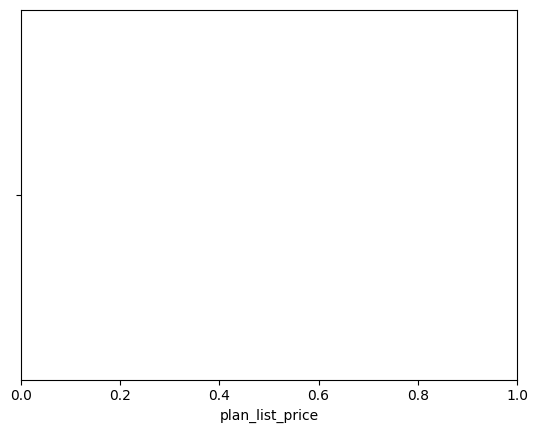

In [169]:
sns.boxplot(x='plan_list_price', data=train_df_n)